In [2]:
import findspark

In [4]:
findspark.init()

In [143]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext as sqlContext
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator

In [82]:
spark = SparkSession.builder.appName('ttss3').getOrCreate()
data=spark.read.csv('/Users/tuanphattrantruong/Documents/blurred-hcmut-data/mssv_dtk_dc_drop_row_all_na.csv', header=True, inferSchema=True)

In [83]:
df=pd.read_csv('/Users/tuanphattrantruong/Documents/blurred-hcmut-data/mssv_dtk_dc_drop_row_all_na.csv')

In [84]:
df.columns

Index(['MASV1', 'LA1003', 'MI1003', 'PE1003', 'CH1003', 'MT1003', 'PH1003',
       'LA1005', 'PE1005', 'MT1005', 'MT1007', 'LA1007', 'MT1009', 'LA1009',
       'MT2001', 'PE1007', 'SP1007', 'SP1003', 'SP1005', 'SP1009'],
      dtype='object')

In [85]:
df.head()

,MASV1,LA1003,MI1003,PE1003,CH1003,MT1003,PH1003,LA1005,PE1005,MT1005,MT1007,LA1007,MT1009,LA1009,MT2001,PE1007,SP1007,SP1003,SP1005,SP1009
0,10438.0,10.0,DT,7.0,7.5,9.0,7.0,10.0,5.0,8.5,6.5,9.5,9.0,7.0,7.0,5.0,NaN,9.0,7.5,7.5
1,15731.0,10.0,DT,7.0,8.0,7.0,5.5,10.0,5.0,7.0,7.0,10.0,7.5,8.0,6.0,8.0,NaN,8.0,NaN,NaN
2,16564.0,10.0,DT,6.0,6.0,6.5,6.0,10.0,5.0,13.0,7.5,10.0,5.0,10.0,4.0,6.0,0.0,7.0,5.5,7.5
3,19461.0,NaN,NaN,6.0,8.5,NaN,NaN,NaN,6.0,7.0,NaN,NaN,NaN,NaN,6.0,3.0,6.5,5.0,7.0,NaN
4,23086.0,6.5,NaN,6.0,NaN,6.5,6.0,6.0,7.0,2.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
df2=df[['MASV1','MT1003','MT1005']]

In [89]:
df2

,MASV1,MT1003,MT1005
0,10438.0,9.0,8.5
1,15731.0,7.0,7.0
2,16564.0,6.5,13.0
3,19461.0,NaN,7.0
4,23086.0,6.5,2.0
5,26172.0,6.0,6.0
6,26306.0,9.0,9.5
7,26565.0,13.0,13.0
8,33974.0,5.5,5.5
9,34462.0,NaN,NaN


In [90]:
df2=df2.dropna(axis=0,how='any')

In [100]:
df2.dtypes

MASV1     float64
MT1003    float64
MT1005    float64
dtype: object

In [94]:
def convert(x):
    try:
        t = float(x)
        return t
    except:
        return 13.0

In [98]:
for x in df2.columns:
    if isinstance(x,object):
        df2[x]= df2[x].map(convert)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
df2

,MASV1,MT1003,MT1005
0,10438.0,9.0,8.5
1,15731.0,7.0,7.0
2,16564.0,6.5,13.0
4,23086.0,6.5,2.0
5,26172.0,6.0,6.0
6,26306.0,9.0,9.5
7,26565.0,13.0,13.0
8,33974.0,5.5,5.5
14,61504.0,8.5,6.5
15,66797.0,5.0,6.5


In [115]:
df2 = df2[(df2.MT1003<10.1) & (df2.MT1005<10.1)]

In [116]:
df2

,MASV1,MT1003,MT1005
0,10438.0,9.0,8.5
1,15731.0,7.0,7.0
4,23086.0,6.5,2.0
5,26172.0,6.0,6.0
6,26306.0,9.0,9.5
8,33974.0,5.5,5.5
14,61504.0,8.5,6.5
15,66797.0,5.0,6.5
16,75321.0,5.0,5.0
17,77173.0,6.5,8.0


In [117]:
mySchema = StructType([StructField("MASV1", FloatType(), True),StructField("MT1003", FloatType(), True),StructField("MT1005", FloatType(), True)])

In [118]:
sdf = spark.createDataFrame(df2,schema=mySchema)


In [119]:
type(sdf)

pyspark.sql.dataframe.DataFrame

In [121]:
vecAssembler = VectorAssembler(inputCols=['MT1003', 'MT1005'], outputCol="features")
df_kmeans = vecAssembler.transform(sdf).select('MASV1', 'features')
df_kmeans.show()

+--------+---------+
|   MASV1| features|
+--------+---------+
| 10438.0|[9.0,8.5]|
| 15731.0|[7.0,7.0]|
| 23086.0|[6.5,2.0]|
| 26172.0|[6.0,6.0]|
| 26306.0|[9.0,9.5]|
| 33974.0|[5.5,5.5]|
| 61504.0|[8.5,6.5]|
| 66797.0|[5.0,6.5]|
| 75321.0|[5.0,5.0]|
| 77173.0|[6.5,8.0]|
| 81657.0|[6.5,6.0]|
| 94690.0|[9.0,6.0]|
|116572.0|[5.5,5.0]|
|118048.0|[6.0,2.0]|
|137129.0|[1.0,0.0]|
|143503.0|[6.0,2.0]|
|158147.0|[0.0,5.5]|
|161614.0|[8.0,9.0]|
|182309.0|[2.5,6.0]|
|195989.0|[7.0,7.5]|
+--------+---------+
only showing top 20 rows



In [123]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans)

Text(0,0.5,'cost')

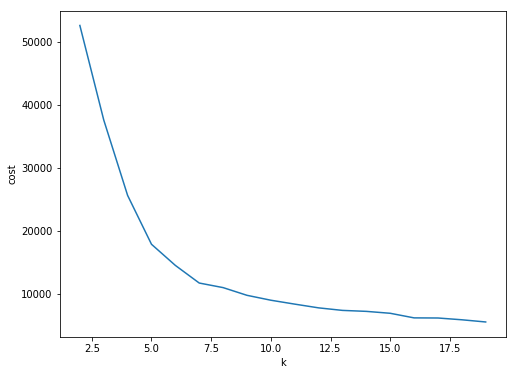

In [126]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [262]:
k = 5
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()


In [263]:
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[5.72053292 5.64677564]
[5.40767477 1.61474164]
[1.7378902  5.32454252]
[1.39153439 1.16031746]
[7.58507509 7.65456821]


In [264]:
transformed = model.transform(df_kmeans).select('MASV1', 'prediction')
rows = transformed.collect()
print(rows)

[Row(MASV1=10438.0, prediction=4), Row(MASV1=15731.0, prediction=4), Row(MASV1=23086.0, prediction=1), Row(MASV1=26172.0, prediction=0), Row(MASV1=26306.0, prediction=4), Row(MASV1=33974.0, prediction=0), Row(MASV1=61504.0, prediction=4), Row(MASV1=66797.0, prediction=0), Row(MASV1=75321.0, prediction=0), Row(MASV1=77173.0, prediction=4), Row(MASV1=81657.0, prediction=0), Row(MASV1=94690.0, prediction=4), Row(MASV1=116572.0, prediction=0), Row(MASV1=118048.0, prediction=1), Row(MASV1=137129.0, prediction=3), Row(MASV1=143503.0, prediction=1), Row(MASV1=158147.0, prediction=2), Row(MASV1=161614.0, prediction=4), Row(MASV1=182309.0, prediction=2), Row(MASV1=195989.0, prediction=4), Row(MASV1=204873.0, prediction=2), Row(MASV1=209312.0, prediction=4), Row(MASV1=216361.0, prediction=0), Row(MASV1=223768.0, prediction=1), Row(MASV1=226368.0, prediction=4), Row(MASV1=251450.0, prediction=4), Row(MASV1=252859.0, prediction=0), Row(MASV1=253551.0, prediction=0), Row(MASV1=268646.0, prediction=

In [265]:
mySchema1 = StructType([StructField("MASV1", FloatType(), True),StructField("prediction", IntegerType(), True)])
rows1 = spark.createDataFrame(rows,schema=mySchema1)
rows1.show()

+--------+----------+
|   MASV1|prediction|
+--------+----------+
| 10438.0|         4|
| 15731.0|         4|
| 23086.0|         1|
| 26172.0|         0|
| 26306.0|         4|
| 33974.0|         0|
| 61504.0|         4|
| 66797.0|         0|
| 75321.0|         0|
| 77173.0|         4|
| 81657.0|         0|
| 94690.0|         4|
|116572.0|         0|
|118048.0|         1|
|137129.0|         3|
|143503.0|         1|
|158147.0|         2|
|161614.0|         4|
|182309.0|         2|
|195989.0|         4|
+--------+----------+
only showing top 20 rows



In [266]:
df_pred = rows1.join(sdf, 'MASV1')
df_pred.show()

+-----------+----------+------+------+
|      MASV1|prediction|MT1003|MT1005|
+-----------+----------+------+------+
|   494028.0|         4|   7.5|   9.0|
|  2896868.0|         1|   4.0|   2.5|
|  4742989.0|         1|   5.0|   0.0|
|  8263150.0|         0|   5.0|   4.0|
|  8773252.0|         3|   1.0|   0.0|
|  8909392.0|         4|   8.0|   7.0|
|1.0072233E7|         4|   5.0|   9.0|
|1.0671582E7|         4|   9.5|   9.0|
|1.1768077E7|         0|   6.5|   5.0|
|1.4150215E7|         0|   6.0|   5.5|
| 1.521343E7|         4|   7.0|   8.5|
|1.5320448E7|         0|   6.0|   4.0|
|1.7479346E7|         4|   7.5|   8.0|
| 1.826279E7|         4|   6.5|   7.0|
|1.9762058E7|         0|   5.0|   6.5|
| 2.132897E7|         1|   4.0|   1.5|
|2.1435982E7|         0|   4.5|   6.0|
|2.2186548E7|         4|   7.0|   8.5|
|2.2272508E7|         4|   7.0|   6.5|
| 2.393056E7|         0|   6.0|   4.5|
+-----------+----------+------+------+
only showing top 20 rows



In [267]:
pddf_pred = df_pred.toPandas().set_index('MASV1')
pddf_pred.shape

(10854, 3)

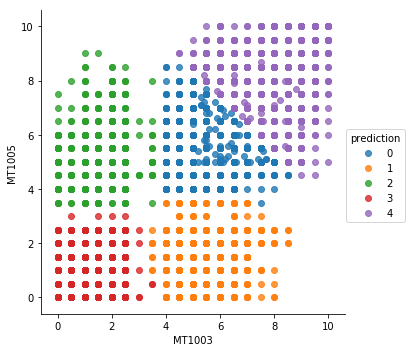

In [268]:
facet = sns.lmplot(data=pddf_pred, x='MT1003', y='MT1005', hue='prediction',
                   fit_reg=False, legend=True, legend_out=True)

In [269]:
adf=pd.read_csv('/Users/tuanphattrantruong/Documents/blurred-hcmut-data/student_info.csv')

In [270]:
adf.shape

(61627, 6)

In [271]:
result = pddf_pred.join(adf.set_index('MASV1'))

In [272]:
result.sort_values(by='prediction', ascending=False)

,prediction,MT1003,MT1005,F_MAKH,F_TENLOP,F_KHOI,F_MANG,F_TENNGVN
MASV1,,,,,,,,
10438.0,4,9.0,8.5,CK,CK14CK10,DHCKCKI14,CKI,Cơ khí-Cơ điện tử
48990036.0,4,8.0,8.5,NaN,NaN,NaN,NaN,NaN
49208072.0,4,7.5,7.5,NaN,NaN,NaN,NaN,NaN
49177584.0,4,6.0,8.5,NaN,NaN,NaN,NaN,NaN
49101568.0,4,7.5,6.5,DD,DD17LT12,DHDDDDT17,DDT,Điện - Điện tử
49088628.0,4,8.5,8.0,MT,MT1408,DHMTCTT14,CTT,MT&CôngNghệ ThôngTin
49054144.0,4,8.0,6.5,NaN,NaN,NaN,NaN,NaN
49049392.0,4,8.5,8.0,NaN,NaN,NaN,NaN,NaN
49025396.0,4,7.0,6.5,NaN,NaN,NaN,NaN,NaN


In [228]:
result.loc[result['prediction'] == 5]

,prediction,MT1003,MT1005,F_MAKH,F_TENLOP,F_KHOI,F_MANG,F_TENNGVN
MASV1,,,,,,,,
137129.0,5,1.0,0.0,XD,XD17XD02,DHXDXDG17,XDG,Xây dựng
333096.0,5,0.5,2.5,UD,KU1603,DHUDCVK16,CVK,Cơ KT- Vật lý KT
481259.0,5,2.0,2.0,HC,HC14HC05,DHHCHTS14,HTS,Hóa-ThựcPhẩm-SinhHọc
543191.0,5,2.0,2.0,VL,VL1605,DHVLVL116,VL1,Kỹ Thuật Vật Liệu
683324.0,5,0.0,0.0,XD,XD17VL,DHXDVXD17,VXD,Vật liệu Xây dựng
793960.0,5,1.0,1.0,VL,VL1404,DHVLVL114,VL1,Kỹ Thuật Vật Liệu
838633.0,5,1.5,1.0,XD,XD17XD06,DHXDXDG17,XDG,Xây dựng
854428.0,5,2.0,1.5,XD,XD16XD04,DHXDXDG16,XDG,Xây dựng
1041586.0,5,0.0,2.0,CK,CK17CK06,DHCKCKI17,CKI,Cơ khí-Cơ điện tử


In [254]:
result.loc[result['prediction'] == 5]['F_MAKH'].value_counts()

XD    90
CK    74
VL    37
DD    29
UD    29
HC    28
GT    19
MT    17
MO    17
DC    11
Name: F_MAKH, dtype: int64

In [273]:
result.loc[result['prediction'] == 4]['F_MAKH'].value_counts()

DD    311
HC    255
CK    236
MT    155
XD    124
GT     40
DC     38
VL     31
UD     29
MO     16
Name: F_MAKH, dtype: int64

In [274]:
result.loc[result['prediction'] == 3]['F_MAKH'].value_counts()

XD    104
CK     56
VL     48
DD     32
HC     18
MT     16
MO     16
GT     13
DC     13
UD     12
Name: F_MAKH, dtype: int64

In [275]:
result.loc[result['prediction'] == 2]['F_MAKH'].value_counts()

XD    91
CK    74
VL    37
DD    29
UD    29
HC    28
GT    19
MT    17
MO    17
DC    12
Name: F_MAKH, dtype: int64

In [276]:
result.loc[result['prediction'] == 1]['F_MAKH'].value_counts()

XD    112
CK     98
DD     82
MT     58
HC     43
VL     27
GT     23
DC     16
UD     15
MO     13
Name: F_MAKH, dtype: int64

In [277]:
result.loc[result['prediction'] == 0]['F_MAKH'].value_counts()

XD    322
CK    307
DD    281
HC    209
MT    157
UD     84
VL     80
GT     79
MO     75
DC     54
QL      1
Name: F_MAKH, dtype: int64

In [261]:
result.loc[result['prediction'] == 6]['F_MAKH'].value_counts()

XD    58
CK    38
DD    31
MT    21
VL    15
GT    14
UD    10
HC    10
DC     7
MO     7
Name: F_MAKH, dtype: int64